# Sentiments Analysis
liens : https://realpython.com/python-keras-text-classification/#keras-embedding-layer

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter


import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns

## sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## keras
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## propre librairie
from utils.text_utils import clean_sentence, encode_sentence

## 1. Choosing the Data Set

In [2]:
data_file = 'datas/text_emotion.csv'
data = pd.read_csv(data_file)

In [3]:
data.head(5)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [4]:
data.describe(include='all')

,tweet_id,sentiment,author,content
count,4.000000e+04,40000,40000,40000
unique,NaN,13,33871,39827
top,NaN,neutral,MissxMarisa,I just received a mothers day card from my lov...
freq,NaN,8638,23,14
mean,1.845184e+09,NaN,NaN,NaN
std,1.188579e+08,NaN,NaN,NaN
min,1.693956e+09,NaN,NaN,NaN
25%,1.751431e+09,NaN,NaN,NaN
50%,1.855443e+09,NaN,NaN,NaN
75%,1.962781e+09,NaN,NaN,NaN


In [5]:
data.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

<IPython.core.display.Javascript object>


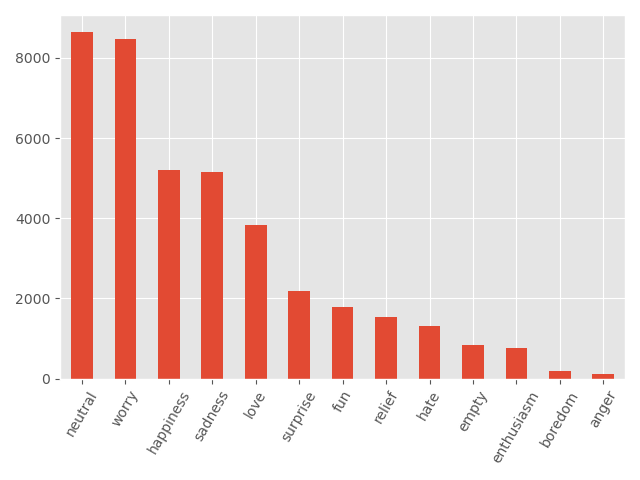

<AxesSubplot:>

In [7]:
data['sentiment'].value_counts().plot(kind='bar', rot=60)

In [8]:
# clean content (remove handles, links, punctuation, stop words, and apply stemmer)
data['clean_content'] = data['content'].apply(clean_sentence)
data.head()

,tweet_id,sentiment,author,content,clean_content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,know listenin bad habit ear start freakin part
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,layin bed headach ughhh waitin cal
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,fun ceremony gloom friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,want hang friend soon
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,want trad someon houston ticket on


<IPython.core.display.Javascript object>


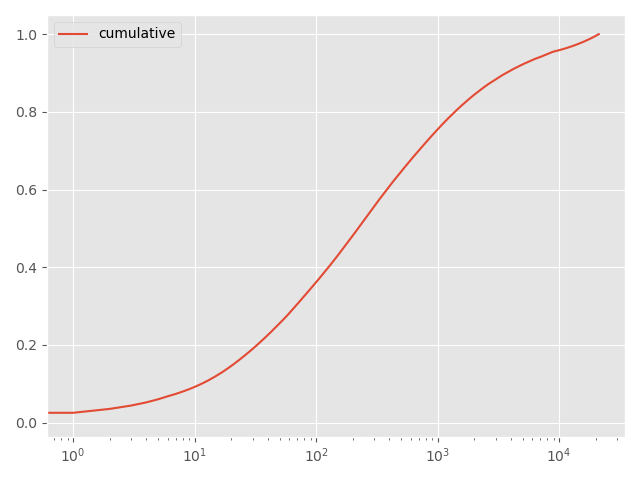

In [9]:
# look at distribution of most common words
counter = Counter()
for _, row in data.iterrows():
    counter.update(row['clean_content'].split())
counts = pd.DataFrame(counter.most_common(), columns=['word', 'count'])
counts['cumulative'] = counts['count'].cumsum() / counts['count'].sum()

counts.plot(y='cumulative', logx=True, grid=True)
plt.show()

In [10]:
# encode label values
labels = {value: idx for idx, value in enumerate(data['sentiment'].unique())}
labels

{'empty': 0,
 'sadness': 1,
 'enthusiasm': 2,
 'neutral': 3,
 'worry': 4,
 'surprise': 5,
 'love': 6,
 'fun': 7,
 'hate': 8,
 'happiness': 9,
 'boredom': 10,
 'relief': 11,
 'anger': 12}

In [11]:
data['label'] = data['sentiment'].apply(lambda x: labels[x])
data.head()

,tweet_id,sentiment,author,content,clean_content,label
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,know listenin bad habit ear start freakin part,0
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,layin bed headach ughhh waitin cal,1
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,fun ceremony gloom friday,1
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,want hang friend soon,2
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,want trad someon houston ticket on,3


In [12]:
data.drop(['tweet_id', 'author'], axis=1, inplace=True)

### Plot distributrion of sentences length

In [13]:
import statistics
len_sentence = data.clean_content.map(lambda x: len(x))
# stats to decide on the optimal length of the sentence.
median_length = statistics.median(len_sentence)
print("Median length :", median_length)
mean_length = statistics.mean(len_sentence)
print("Mean length :", mean_length)
st_dev = statistics.stdev(len_sentence)
print("Standard déviation :", st_dev)

Median length : 32.0
Mean length : 34.871825
Standard déviation : 19.865232489349864


<IPython.core.display.Javascript object>


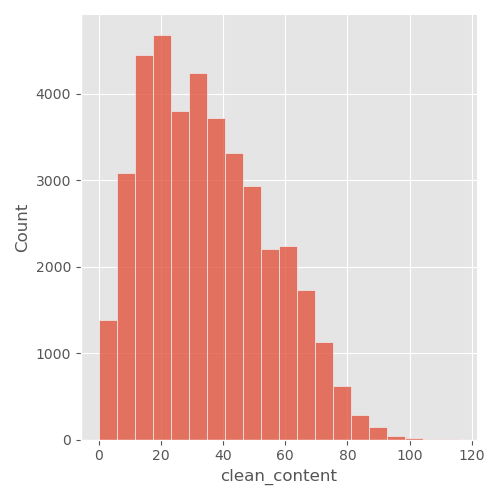

In [14]:
sns.displot(x=len_sentence, bins=20)

## 2. Defining a Baseline Model
### Separate train and test set

In [15]:
sentences = data['clean_content'].values
y = data['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000, shuffle=True, stratify=y)


'charl lov miss'

In [16]:
import nltk
stopwords = nltk.corpus.stopwords.words("english")
vectorizer = CountVectorizer(stop_words= stopwords)
vectorizer.fit(sentences)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<30000x21118 sparse matrix of type '<class 'numpy.int64'>'
	with 195088 stored elements in Compressed Sparse Row format>

In [17]:
len(vectorizer.get_feature_names())

21118

### Generate the baseline model

In [18]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.3349


/home/anthony/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3. First deep learning model using Keras 

### Create the model

In [19]:
## clear the session of model fit
clear_session()

input_dim = X_train.shape[1]  # Number of features
n_hyden_layer = 2
n_percept = 100
activ_hid = 'elu'
activ_out = 'softmax'
n_out_percept = data['label'].nunique()

def create_model(input_dim, n_hyden_layer=1, n_percept=8, \
                 activ_hid='relu', activ_out='sigmoid', n_out_percept=1):
    model = Sequential()
    for i in range(n_hyden_layer):
        model.add(layers.Dense(n_percept, input_dim=input_dim, activation=activ_hid))
    model.add(layers.Dense(n_out_percept, activation=activ_out))
    return model

In [20]:
model = create_model(input_dim, n_hyden_layer, n_percept, activ_hid, activ_out, n_out_percept)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2111900   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 13)                1313      
Total params: 2,123,313
Trainable params: 2,123,313
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [21]:
model_history = model.fit(X_train, y_train,
                          epochs=20,
                          verbose=True,
                          validation_data=(X_test, y_test),
                          batch_size=10000) ## nb échantillon échantillon par epoch pour l'entreinement

Epoch 1/20
3/3 [==============================] - 3s 830ms/step - loss: 2.5519 - accuracy: 0.1411 - val_loss: 2.4997 - val_accuracy: 0.2699
Epoch 2/20
3/3 [==============================] - 1s 313ms/step - loss: 2.4695 - accuracy: 0.3195 - val_loss: 2.4230 - val_accuracy: 0.2591
Epoch 3/20
3/3 [==============================] - 1s 310ms/step - loss: 2.3746 - accuracy: 0.3061 - val_loss: 2.3382 - val_accuracy: 0.2516
Epoch 4/20
3/3 [==============================] - 1s 275ms/step - loss: 2.2723 - accuracy: 0.2973 - val_loss: 2.2587 - val_accuracy: 0.2490
Epoch 5/20
3/3 [==============================] - 1s 254ms/step - loss: 2.1794 - accuracy: 0.2968 - val_loss: 2.1996 - val_accuracy: 0.2570
Epoch 6/20
3/3 [==============================] - 1s 265ms/step - loss: 2.1092 - accuracy: 0.3142 - val_loss: 2.1617 - val_accuracy: 0.2746
Epoch 7/20
3/3 [==============================] - 1s 321ms/step - loss: 2.0433 - accuracy: 0.3562 - val_loss: 2.1327 - val_accuracy: 0.2945
Epoch 8/20
3/3 [====

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<IPython.core.display.Javascript object>


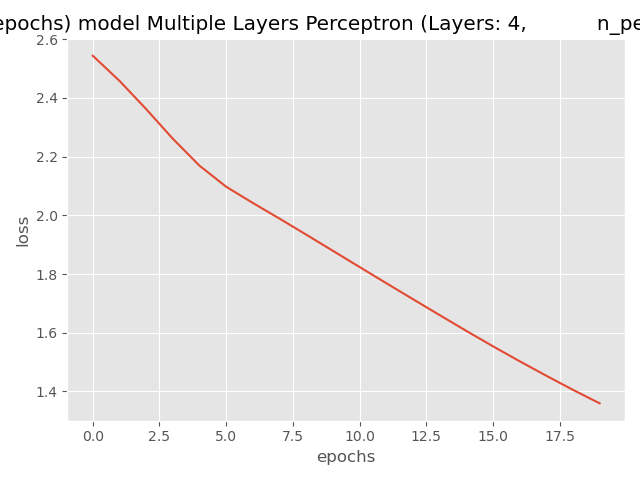

Text(0.5, 1.0, 'MSE = f(epochs) model Multiple Layers Perceptron (Layers: 4,           n_perseptron : 100')

In [22]:
# list all data in history
print(model_history.history.keys())

# summarize history for accuracy
plt.plot(model_history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title(f'MSE = f(epochs) model Multiple Layers Perceptron (Layers: {n_hyden_layer+2}, \
          n_perseptron : {n_percept}')

### Evaluation du model

In [23]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5926
Testing Accuracy:  0.3310


In [24]:
def plot_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

<IPython.core.display.Javascript object>


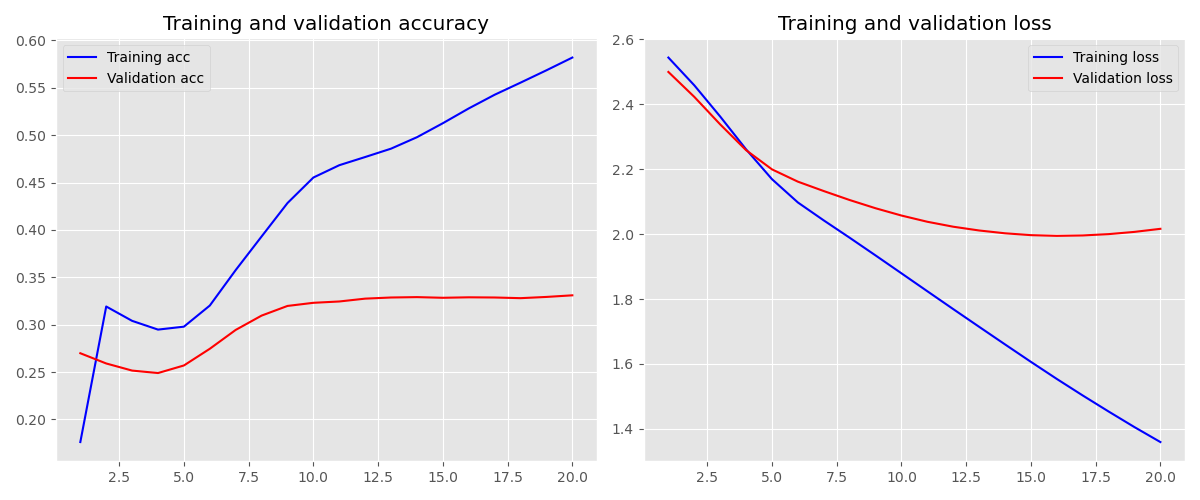

In [25]:
plot_history(model_history)

Rq : La courbe de validation loss commence à remonter à partir de 10 epochs d'après la courbe et nous sommes ensuite en sur- apprentissage -> **Limiter dans notre cas l'apprentissage à 10 epochs** 

## 4. Word Embeddings


In [26]:
tokenizer = Tokenizer(num_words=len(vectorizer.get_feature_names()))
tokenizer.fit_on_texts(sentences)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

## word map index
word_to_index = tokenizer.word_index

print(sentences_train[0])
print(X_train[0])

anticip mak cup tea im agr must hap awesom
[2535, 31, 753, 466, 2, 528, 220, 176, 86]


In [27]:
for word in ['the', 'all']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 605
all: 1642


In [28]:
data.clean_content

0           know listenin bad habit ear start freakin part
1                     layin bed headach ughhh  waitin cal 
2                              fun ceremony  gloom friday 
3                                    want hang friend soon
4                       want trad someon houston ticket on
                               ...                        
39995                                                     
39996                                   happy moth day lov
39997    happy moth day mommy wom man long momm someon day
39998    wassup beauty follow peep new hit singl wwwmys...
39999    bullet train tokyo visit jap sint thursday vac...
Name: clean_content, Length: 40000, dtype: object

In [29]:
print(data.clean_content.map(lambda x: len(x)).max())
maxlen = max(data['clean_content'].apply(len))
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

116
[2535   31  753  466    2  528  220  176   86    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


## 5. Keras Embedding Layer

In [30]:
embedding_dim = 50

## clear the session of model fit
clear_session()

input_dim = X_train.shape[1]  # Number of features
n_hyden_layer = 1
n_percept = 10
activ_hid = 'elu'
activ_out = 'softmax'
n_out_percept = data['label'].nunique()

def create_model_embedded(vocab_size, embedding_dim = 50, n_hyden_layer=1, n_percept=8, \
                 activ_hid='relu', activ_out='sigmoid', n_out_percept=13):
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.Flatten())
    
    ## couches cachés denses
    for i in range(n_hyden_layer):
        model.add(layers.Dense(n_percept, activation=activ_hid))
    model.add(layers.Dense(n_out_percept, activation=activ_out))
    return model

model = create_model_embedded(vocab_size, embedding_dim, n_hyden_layer, n_percept, activ_hid, activ_out, n_out_percept)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', ## sparse_categorical_crossentropy
              metrics=['accuracy']) ## 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 50)           1059500   
_________________________________________________________________
flatten (Flatten)            (None, 5800)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                58010     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                143       
Total params: 1,117,653
Trainable params: 1,117,653
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_history = model.fit(X_train, y_train,
                          epochs=20,
                          verbose=True, # True or 1 -> progress bar  // 2 -> 1 ligne per epoch
                          validation_data=(X_test, y_test),
                          batch_size=1000)

Epoch 1/20
30/30 [==============================] - 5s 135ms/step - loss: 2.3625 - accuracy: 0.1950 - val_loss: 2.1794 - val_accuracy: 0.2494
Epoch 2/20
30/30 [==============================] - 3s 107ms/step - loss: 2.1585 - accuracy: 0.2563 - val_loss: 2.1370 - val_accuracy: 0.2580
Epoch 3/20
30/30 [==============================] - 3s 109ms/step - loss: 2.1105 - accuracy: 0.2726 - val_loss: 2.1128 - val_accuracy: 0.2664
Epoch 4/20
30/30 [==============================] - 3s 115ms/step - loss: 2.0640 - accuracy: 0.2954 - val_loss: 2.0825 - val_accuracy: 0.2897
Epoch 5/20
30/30 [==============================] - 3s 104ms/step - loss: 1.9936 - accuracy: 0.3427 - val_loss: 2.0530 - val_accuracy: 0.3021
Epoch 6/20
30/30 [==============================] - 3s 100ms/step - loss: 1.9035 - accuracy: 0.3821 - val_loss: 2.0333 - val_accuracy: 0.3176
Epoch 7/20
30/30 [==============================] - 3s 105ms/step - loss: 1.8039 - accuracy: 0.4282 - val_loss: 2.0251 - val_accuracy: 0.3244
Epoch 

Training Accuracy: 0.8073
Testing Accuracy:  0.2933


<IPython.core.display.Javascript object>


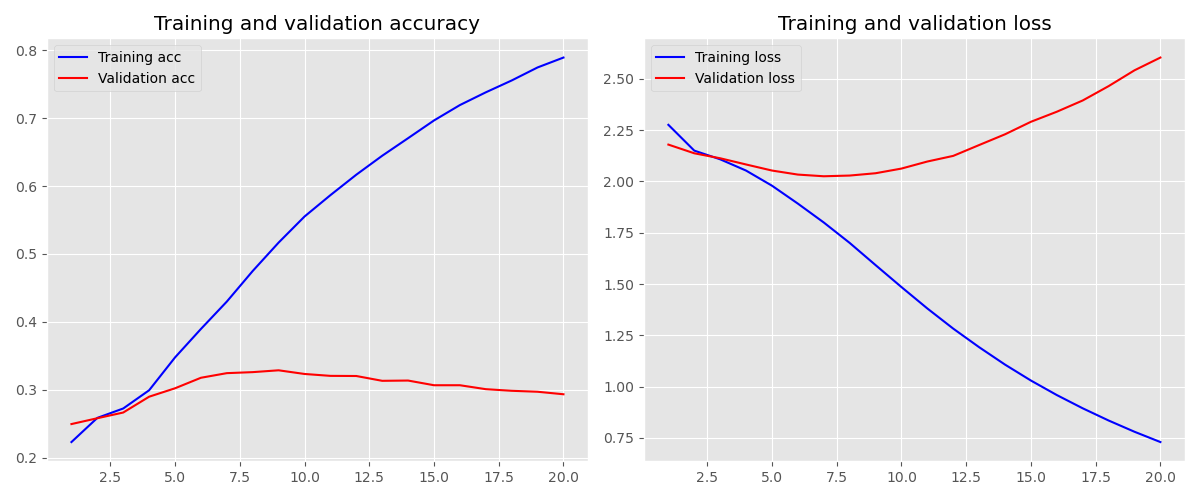

In [32]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(model_history)


In [34]:
# prediction on test data for prediction Metrics
y_pred = model.predict(X_test)
#Y_test = np.argmax(y_test, axis=1) 
y_pred_class = np.argmax(y_pred, axis=1) 

In [35]:
from sklearn.metrics import classification_report
# Classification report for the predicted results.

classes = list(labels.keys())
print(classification_report(y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

       empty       0.00      0.00      0.00       207
     sadness       0.25      0.28      0.26      1291
  enthusiasm       0.00      0.00      0.00       190
     neutral       0.32      0.47      0.38      2159
       worry       0.31      0.35      0.33      2115
    surprise       0.11      0.04      0.06       547
        love       0.33      0.35      0.34       960
         fun       0.09      0.05      0.06       444
        hate       0.29      0.11      0.17       331
   happiness       0.29      0.30      0.30      1302
     boredom       0.00      0.00      0.00        45
      relief       0.06      0.00      0.01       381
       anger       0.00      0.00      0.00        28

    accuracy                           0.29     10000
   macro avg       0.16      0.15      0.15     10000
weighted avg       0.26      0.29      0.27     10000



/home/anthony/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anthony/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anthony/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### embedding matrix

In [36]:
# access the embedding layer through the constructed model 
# first `0` refers to the position of embedding layer in the `model`
embeddings = model.layers[0].get_weights()[0]

# `embeddings` has a shape of (num_vocab, embedding_dim) 

# `word_to_index` is a mapping (i.e. dict) from words to their index
words_embeddings = {w:embeddings[idx] for w, idx in word_to_index.items()}

# now you can use it like this for example
print(words_embeddings['cat']) 

[ 0.06044008 -0.08252882  0.03245671  0.02961979  0.20372364  0.02437478
  0.05390922  0.04801363 -0.05435371 -0.01368119  0.01681867  0.1412567
 -0.04467111 -0.02058737  0.05233049  0.01992144 -0.01260816 -0.04902097
  0.00570534  0.0687831  -0.01655728  0.08006187 -0.03325616  0.07294015
  0.1053625   0.03632068 -0.12909198  0.06548672  0.06002039 -0.07990097
 -0.05587847 -0.06496357 -0.02375619 -0.05240539  0.0040988  -0.00900042
  0.01948419  0.15309982 -0.06478301 -0.13348024 -0.09609072 -0.11474692
  0.09223575  0.00284881  0.04106216 -0.05474425 -0.17638387  0.04678797
  0.20641178 -0.09211726]


In [37]:
def cos_sim(a, b):
    for name_a, val_a in a.items(): pass
    for name_b, val_b in b.items(): pass
    cosim = np.dot(val_a, val_b)/(np.linalg.norm(val_a)*np.linalg.norm(val_b))
    print(f"similarity between {name_a} and {name_b} : {cosim}")
    return cosim

dog = {'dog': words_embeddings['dog']}
cat = {'cat' : words_embeddings['cat']}
simil = cos_sim(dog, cat)

similarity between dog and cat : -0.15739864110946655


In [40]:
embedding_dim = 260

## clear the session of model fit
clear_session()

input_dim = X_train.shape[1]  # Number of features
n_hyden_layer = 1
n_percept = 128
activ_hid = 'elu'
activ_out = 'softmax'
n_out_percept = data['label'].nunique()

def create_model_embedded(vocab_size, embedding_dim = 50, n_hyden_layer=1, n_percept=8, \
                 activ_hid='relu', activ_out='sigmoid', n_out_percept=13):
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.GlobalMaxPool1D())
    
    ## couches cachés denses
    for i in range(n_hyden_layer):
        model.add(layers.Dense(n_percept, activation=activ_hid))
        model.add(layers.Dropout(.5, input_shape=(n_percept,)))
    model.add(layers.Dense(n_out_percept, activation=activ_out))
    return model

model = create_model_embedded(vocab_size, embedding_dim, n_hyden_layer, n_percept, activ_hid, activ_out, n_out_percept)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', ## sparse_categorical_crossentropy
              metrics=['accuracy']) ## 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 260)          5509400   
_________________________________________________________________
global_max_pooling1d (Global (None, 260)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               33408     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1677      
Total params: 5,544,485
Trainable params: 5,544,485
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_history = model.fit(X_train, y_train,
                          epochs=12,
                          verbose=True, # True or 1 -> progress bar  // 2 -> 1 ligne per epoch
                          validation_data=(X_test, y_test),
                          batch_size=2048)

Epoch 1/12
15/15 [==============================] - 11s 539ms/step - loss: 2.4483 - accuracy: 0.1853 - val_loss: 2.1904 - val_accuracy: 0.2251
Epoch 2/12
15/15 [==============================] - 7s 476ms/step - loss: 2.1869 - accuracy: 0.2341 - val_loss: 2.1346 - val_accuracy: 0.2555
Epoch 3/12
15/15 [==============================] - 7s 490ms/step - loss: 2.1374 - accuracy: 0.2492 - val_loss: 2.1053 - val_accuracy: 0.2667
Epoch 4/12
15/15 [==============================] - 7s 491ms/step - loss: 2.0886 - accuracy: 0.2798 - val_loss: 2.0615 - val_accuracy: 0.2884
Epoch 5/12
15/15 [==============================] - 7s 495ms/step - loss: 2.0076 - accuracy: 0.3348 - val_loss: 2.0017 - val_accuracy: 0.3220
Epoch 6/12
15/15 [==============================] - 8s 508ms/step - loss: 1.9043 - accuracy: 0.3844 - val_loss: 1.9506 - val_accuracy: 0.3420
Epoch 7/12
15/15 [==============================] - 7s 483ms/step - loss: 1.7908 - accuracy: 0.4233 - val_loss: 1.9271 - val_accuracy: 0.3495
Epoch

Training Accuracy: 0.6522
Testing Accuracy:  0.3420


<IPython.core.display.Javascript object>


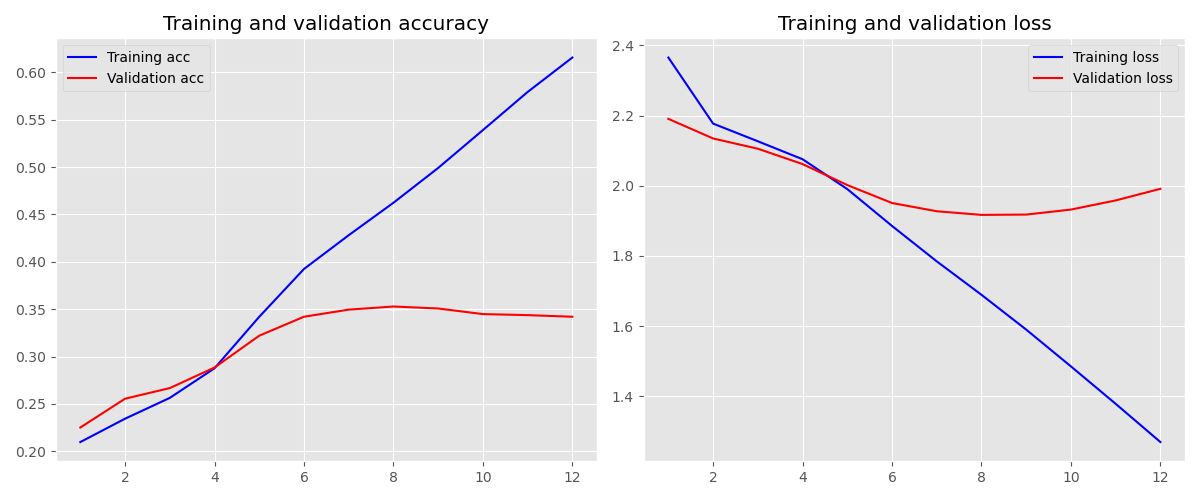

In [42]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(model_history)


In [43]:
# prediction on test data for prediction Metrics
y_pred = model.predict(X_test)
#Y_test = np.argmax(y_test, axis=1) 
y_pred_class = np.argmax(y_pred, axis=1) 

In [44]:
from sklearn.metrics import classification_report
# Classification report for the predicted results.

classes = list(labels.keys())
print(classification_report(y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

       empty       0.00      0.00      0.00       207
     sadness       0.32      0.27      0.29      1291
  enthusiasm       0.00      0.00      0.00       190
     neutral       0.35      0.50      0.41      2159
       worry       0.32      0.47      0.38      2115
    surprise       0.26      0.01      0.03       547
        love       0.46      0.39      0.42       960
         fun       0.11      0.00      0.01       444
        hate       0.50      0.19      0.27       331
   happiness       0.32      0.43      0.36      1302
     boredom       0.00      0.00      0.00        45
      relief       0.00      0.00      0.00       381
       anger       0.00      0.00      0.00        28

    accuracy                           0.34     10000
   macro avg       0.20      0.17      0.17     10000
weighted avg       0.31      0.34      0.31     10000



/home/anthony/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anthony/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anthony/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

## Explaining predictions using lime

In [45]:
from lime import lime_text
import lime

In [77]:
class_names = [k for k,v in labels.items()]
class_names

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

In [78]:
X_test.shape

(10000, 116)

In [79]:
np.array([X_test[7,:]])

array([[ 909,  316,  619,  392, 2613,   55,    2,  311,  130, 5624,   27,
         412, 2719, 3656,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [88]:
print(model.predict(np.array([X_test[7,:]])).round(3))

[[0.017 0.224 0.03  0.051 0.226 0.095 0.023 0.105 0.075 0.097 0.008 0.045
  0.005]]


In [81]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [91]:
sentences_test[7]

'fml forgot al dant recit tonight im stuck talk munchkin night instead devon bonfir'

In [ ]:
idx = 7
exp = explainer.explain_instance([sentences_test[idx]], model.predict, num_features=6)
print('Document id: %d' % idx)
print('Predicted class =', class_names[np.argmax(model.predict(np.array([X_test[idx,:]])), axis=1)\
                                       .reshape(1,-1)[0,0]])
print('True class: %s' % class_names[y_test[idx]])

In [41]:
embedding_dim = 100

## clear the session of model fit
clear_session()

input_dim = X_train.shape[1]  # Number of features
n_hyden_layer = 1
n_percept = 128
activ_hid = 'elu'
activ_out = 'softmax'
n_out_percept = data['label'].nunique()

def create_model_embedded(vocab_size, embedding_dim = 50, n_hyden_layer=1, n_percept=8, \
                 activ_hid='relu', activ_out='sigmoid', n_out_percept=13):
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    
    model.add(layers.Dense(n_out_percept, activation=activ_out))
    return model

model = create_model_embedded(vocab_size, embedding_dim, n_hyden_layer, n_percept, activ_hid, activ_out, n_out_percept)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', ## sparse_categorical_crossentropy
              metrics=['accuracy']) ## 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 100)          2119000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 13)                1677      
Total params: 2,237,925
Trainable params: 2,237,925
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history = model.fit(X_train, y_train,
                          epochs=36,
                          verbose=True, # True or 1 -> progress bar  // 2 -> 1 ligne per epoch
                          validation_data=(X_test, y_test),
                          batch_size=128)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(model_history)


In [ ]:
# prediction on test data for prediction Metrics
y_pred = model.predict(X_test)
#Y_test = np.argmax(y_test, axis=1) 
y_pred_class = np.argmax(y_pred, axis=1) 

In [ ]:
from sklearn.metrics import classification_report
# Classification report for the predicted results.

classes = list(labels.keys())
print(classification_report(y_test, y_pred_class, target_names=classes))